# MAE 271: Lab 3 - Voice coil actuator installed on quarter car model
### Cooper Cook & Joshua Booth

## Problem Introduction
The simulation problem below presents the sprung mass quarter car model that we have simulated before. This time, we have added a voice coil actuated inertial actuator on top of the sprung mass. This enables us to simulate and test how the current control on the voice coil can generate a force to accelerate the actuator mass that will theoretically react back on the sprung mass and calm the motion of the quarter car model. In this simulation, we are able to test this with a randomly varying road input and different levels of damping control on the actuator.


## Simulation Setup


### Equations used for simulations






## Code Setup
Since we plan to do several simulations and visualize them, in this section we define several functions that allow us to simplify how this is done.

### Define Derivative Function
To solve this non-linear system of ordinary differential equations, we need to start from an initial state, numerically integrate along the state derivatives to find the next state, and repeat as desired

For integration, we will use `scipy.integrate`'s `solve_ivp()`, which takes in a range of time (`t_span`) through which to integrate, a function handle (`func`) that takes in the time and state and returns the derivatives, and the initial condition (`initial`) of the state.

Since we wish to solve this problem using several different parameters, we will define a function `get_func()` that returns a function handle that we can pass to `solve_ivp()`. We also return a function that includes additional state information.

In [1]:
from copy import deepcopy
import numpy as np
import scipy


def get_func(params: dict[str, float]):
    '''
    Generate state derivative calculator functions for current simulation.
    '''
    # Make a copy of the input parameters to ensure the returned function
    # does not change when the original parameters dictionary changes
    params = deepcopy(params)

    # Extract parameters from dict
    g = params["g"]         # Gravitational constant (m/s^2)
    U = params["U"]         # Vehicle speed in x-direction (m/s)
    
    # Masses
    m_tot = params["m_tot"]     # Actuated mass (kg)
    msmus = params["msmus"]     # Sprung to unsprung mass ratio
    m_us = m_tot / (1 + msmus)  # Unsprung mass (kg)
    m_s = m_tot - m_us          # Sprung mass (kg)
    m_a = 0.02 * m_s            # Actuator mass (kg)
    params["m_us"] = m_us
    params["m_s"] = m_s
    params["m_a"] = m_a

    # Passive Stiffness
    w_s = params["w_s"]     # Suspension natural frequency (rad/s)
    k_s = m_s * w_s**2      # Suspension stiffness (N/m)
    params["k_s"] = k_s
    w_wh = params["w_wh"]   # Tire wheel hop frequency (rad/s)
    k_t = m_us * w_wh**2    # Tire stiffness (N/m)
    params["k_t"] = k_t

    # Passive Damping
    zeta_s = params["zeta_s"]       # Passive damping ratio
    b_s = 2 * zeta_s * w_s * m_s    # Suspension damping (N·s/m)
    params["b_s"] = b_s

    # Actuator - Passive
    w_a = 2 * np.pi * 5         # Actuator frequency (rad/s)
    k_a = m_a * w_a**2          # Actuator stiffness (N/m)
    b_a = 2 * 0.1 * w_a * m_a   # Actuator damping (N·s/m)
    params["w_a"] = w_a
    params["k_a"] = k_a
    params["b_a"] = b_a

    # Actuator - Active
    zeta_c = params["zeta_c"]       # Active damping ratio
    T_c = params["T_c"]             # Voice coil coupling constant (N/A)
    R_c = params["R_c"]             # Voice coil winding resistance (Ohms)
    b_c = 2 * zeta_c * w_s * m_s    # Voice coil damping (N·s/m)
    params["b_c"] = b_c

    # Road
    road_delta_x = params["road_delta_x"]       # Distance between randomly generated road heights (m)
    road_length = params["road_length"]         # Road length (m)
    road_max_slope = params["road_max_slope"]   # Maximum instantaneous slope (dy/dx) of road
    X_i = np.arange(0, road_length+road_delta_x, road_delta_x)  # Generate road position vector
    road_slope_raw = np.random.random(np.shape(X_i))    # Generate random slope vector
    slope_i = road_max_slope * (road_slope_raw - np.mean(road_slope_raw)) # Scale and subtract mean from road slope vector
    def slope_interpolator(x: float):
        return np.interp(x, X_i, slope_i)

    # Get initial condition
    initial = [
        0,  # Actuator mass momentum
        0,  # Sprung mass momentum
        0,  # Unsprung mass momentum
        (m_a) * g / k_a,                # Actuator displacement
        (m_a + m_s) * g / k_s,          # Suspension displacement
        (m_a + m_s + m_us) * g / k_t,   # Tire displacement
        ]

    def func(t: float, state: list[float]):
        '''
        Calculate state derivative from current state.

        Parameters:
            t (float): Current time of simulation.
            state (list[float]): Current state of simulation.

        Returns:
            d_state (list[float]): Current state derivative.
            state_ext (dict[str, float]): Extended state information.
        '''
        # Create current extended state dict
        s: dict[str, float] = params.copy()
        s["t"] = t
        
        # Make a copy of state variables in case they get changed
        state = deepcopy(state)
        p_a = state[0]  # Actuator mass momentum
        p_s = state[1]  # Sprung mass momentum
        p_us = state[2] # Unsprung mass momentum
        q_a = state[3]  # Actuator displacement
        q_s = state[4]  # Suspension displacement
        q_t = state[5]  # Tire displacement
        s["p_a"] = p_a
        s["p_s"] = p_s
        s["p_us"] = p_us
        s["q_a"] = q_a
        s["q_s"] = q_s
        s["q_t"] = q_t

        # Position of road and its derivatives
        slope_interp = deepcopy(slope_interpolator)
        X = U * t   # vehicle velocity x time
        Y = np.zeros_like(X)
        dYdX = slope_interp(X)
        s["X"] = X
        s["Y"] = Y
        s["dYdX"] = dYdX

        # Velocities
        v_a = p_a / m_a     # Actuator mass velocity
        v_s = p_s / m_s     # Sprung mass velocity
        v_us = p_us / m_us  # Unsprung mass velocity
        v_in = U * dYdX            # Tire input velocity
        s["v_a"] = v_a
        s["v_s"] = v_s
        s["v_us"] = v_us
        s["v_in"] = v_in

        # Voice Coil Current
        i_c = b_c * v_s / T_c   # Voice coil input current (A)
        e_c = R_c * i_c         # Voice coil input voltage (V)
        P_c = i_c * e_c         # Voice coil power (W)
        s["i_c"] = i_c
        s["e_c"] = e_c
        s["P_c"] = P_c

        # Gravitational Force
        F_g_a = -m_a * g    # Actuator mass gravitational force
        F_g_s = -m_s * g    # Sprung mass gravitational force
        F_g_us = -m_us * g  # Unsprung mass gravitational force
        s["F_g_a"] = F_g_a
        s["F_g_s"] = F_g_s
        s["F_g_us"] = F_g_us

        # Actuator Force
        F_b_a = b_a * (v_s - v_a)   # Actuator damping force
        F_s_a = k_a * q_a           # Actuator spring force
        F_vc = T_c * i_c            # Voice coil force
        F_a = F_b_a + F_s_a + F_vc  # Total actuator force
        s["F_b_a"] = F_b_a
        s["F_s_a"] = F_s_a
        s["F_vc"] = F_vc
        s["F_a"] = F_a
        
        # Suspension Force
        F_b_s = b_s * (v_us - v_s)  # Suspension damping force
        F_s_s = k_s * q_s           # Suspension spring force
        F_s = F_b_s + F_s_s         # Total suspension force
        s["F_b_s"] = F_b_s
        s["F_s_s"] = F_s_s
        s["F_s"] = F_s
        
        # Tire Force
        F_t = k_t * q_t if q_t > 0 else 0   # Prevent tire sticking the ground
        s["F_t"] = F_t

        # State Derivatives
        d_p_a = F_g_a + F_a
        d_p_s = F_g_s + F_s - F_a
        d_p_us = F_g_us + F_t - F_s
        d_q_a = v_s - v_a
        d_q_s = v_us - v_s
        d_q_t = v_in - v_us
        s["d_p_a"] = d_p_a
        s["d_p_s"] = d_p_s
        s["d_p_us"] = d_p_us
        s["d_q_a"] = d_q_a
        s["d_q_s"] = d_q_s
        s["d_q_t"] = d_q_t

        # Concatenate state derivatives
        d_state: list[float] = [
            d_p_a,
            d_p_s,
            d_p_us,
            d_q_a,
            d_q_s,
            d_q_t, # Don't worry, this is a float, not an NDArray
            ]

        return d_state, s

    def func_wrap(t: float, state: list[float]):
        """
        Since solve_ivp() needs a function that only returns the state
        derivatives, we create a wrapper for func() that discards the rest of
        the state and returns only the state derivatives
        """
        d_state, _ = func(t, state)
        return d_state

    return func, func_wrap, initial

### Propagate Solution Using `solve_ivp()`
Now that we have a function that calculates the state derivatives given the state, we need to propagate the solution throughout time. The function `solve_problem()` was designed to use the `get_func()` function we defined earlier, calculate the solution using `scipy.integrate`'s `solve_ivp()`, and consolidate the interesting parts of the solution and the parameters given to define it. 

In [2]:
from get_func import get_func
from scipy.integrate import solve_ivp
import pandas as pd
import numpy as np


def solve_problem(
        params: dict[str, float],
        t_eval: np.ndarray,
        name: str,
        rtol: float = 1e-12,
        atol: float = 1e-12,
    ):

    func, func_wrap, initial = get_func(params)
    output = solve_ivp(
        func_wrap,
        (min(t_eval), max(t_eval)),
        initial,
        t_eval=t_eval,
        method="RK45",
        rtol=rtol,
        atol=atol,
    )

    ts = output.t
    ys = output.y

    states: list[dict[str, float]] = []
    for t, y in zip(ts, ys.T):
        d_state, state = func(t, y)
        states.append(state)

    df = pd.DataFrame(states)

    solution = {
        "params": params.copy(),
        "data": df,
        "name": name,
    }

    return solution



### Define Plotting Functions
To visualize the solutions, we can create a static plot or an animation of the pendulum. Since we have several solutions we would like to plot together, we create functions to consolidate the code. `plot_time()` and `plot_ani()` each take in a list of dictionaries outputted as the solution from `solve_problem()`.

In [3]:
from typing import Any
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd


def plot_time(solutions):
    fig = plt.figure()
    ax = fig.add_subplot()
    for solution in solutions:
        name = solution["name"]
        df = solution["data"]

        t_vals = df.get("t").to_numpy()
        X_vals = df.get("X").to_numpy()
        Y_vals = df.get("Y").to_numpy()
        x_vals = df.get("x").to_numpy()
        y_vals = df.get("y").to_numpy()
        px_vals = df.get("px").to_numpy()
        py_vals = df.get("py").to_numpy()
        d_px_vals = df.get("d_px").to_numpy()
        d_py_vals = df.get("d_py").to_numpy()
        theta_vals = df.get("theta").to_numpy() * 180 / np.pi
        tan_theta_vals = df.get("tan_theta").to_numpy()

        # ax.plot(t_vals, x_vals, label=f"{name}: x")
        # ax.plot(t_vals, y_vals, label=f"{name}: y")
        # ax.plot(t_vals, d_px_vals, label=f"{name}: d_px")
        ax.plot(t_vals, theta_vals, label=f"theta: {name}")
        # theta_ax.plot(ts, tan_theta_vals, label="tan_theta")
    plt.legend()
    plt.title("Theta vs. Time")
    plt.xlabel("time (s)")
    plt.ylabel("theta (deg)")
    return fig


def plot_ani(solutions: list[dict[str, Any]], interval: int = 10):
    fig = plt.figure()
    ax = fig.add_subplot()
    all_x = np.array([])
    all_y = np.array([])

    # Initialize arrays to store the animation plots and data to use to update them
    num_solutions = len(solutions)
    plots: list[dict[str, Line2D]] = [{} for _ in range(num_solutions)]
    data: list[dict[str, np.ndarray]] = [{} for _ in range(num_solutions)]

    for i, solution in enumerate(solutions):
        name: str = solution["name"]
        df: pd.DataFrame = solution["data"]

        data[i]["t_vals"] = df.get("t").to_numpy()
        data[i]["X_vals"] = df.get("X").to_numpy()
        data[i]["Y_vals"] = df.get("Y").to_numpy()
        data[i]["y_us_vals"] = df.get("q_t").to_numpy()
        data[i]["y_s_vals"] = df.get("q_s").to_numpy() + data[i]["y_us_vals"]
        data[i]["y_a_vals"] = df.get("q_a").to_numpy() + data[i]["y_s_vals"]

        if i == 0:
            road = ax.plot(data[i]["X_vals"], data[i]["Y_vals"], "-", c="k", label="road")

        (plots[i]["unsprung"],) = ax.plot([], [], "o", label=f"unsprung: {name}")
        (plots[i]["sprung"],) = ax.plot([], [], "o", label=f"sprung: {name}")
        (plots[i]["actuator"],) = ax.plot([], [], "o", label=f"actuator: {name}")

        num_frames = len(data[i]["t_vals"])

        all_x = np.concatenate((all_x, data[i]["X_vals"].copy()))
        all_y = np.concatenate((all_y, data[i]["Y_vals"].copy(),
                                              data[i]["y_us_vals"].copy(),
                                              data[i]["y_s_vals"].copy(),
                                              data[i]["y_a_vals"].copy()
                                              ))

    def update_points(n):
        returns = []
        for i in range(num_solutions):
            plots[i]["unsprung"].set_data(([data[i]["X_vals"][n]], [data[i]["y_us_vals"][n]]))
            plots[i]["sprung"].set_data(([data[i]["X_vals"][n]], [data[i]["y_s_vals"][n]]))
            plots[i]["actuator"].set_data(([data[i]["X_vals"][n]], [data[i]["y_a_vals"][n]]))
            returns.extend([plots[i]["unsprung"], plots[i]["sprung"], plots[i]["actuator"]])

        returns = tuple(returns)
        return (*returns,)

    ani = animation.FuncAnimation(
        fig, update_points, num_frames, interval=interval, blit=True, repeat=True
    )

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    plt.xlim(min_x - 0.5, max_x + 0.5)
    plt.ylim(min_y - 0.5, max_y + 0.5)
    plt.legend()
    plt.title("Pendulum Animation")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    return ani


## Simulation
### Validation (Unexcited Pendulum)
Before running the simulation with the cart moving, we can run it without the moving cart to see if the pendulum behaves as expected, neither gaining nor losing energy.

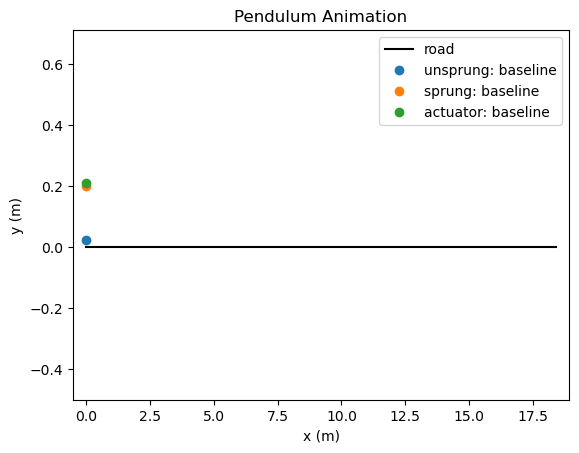

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from solve_problem import solve_problem
from plot import plot_time, plot_ani
plt.rcParams["animation.html"] = "jshtml"

# -----------------------------
# Initial Global Parameters
# -----------------------------
params: dict[str, float] = {}

# Constants
params["g"] = 9.8  # gravity (m/s^2)

# Mass
params["m_tot"] = 3000.0 / 2.2  # Total vehicle mass (lbs -> kg)
params["msmus"] = 5.0           # Sprung to unsprung mass ratio

# Damping ratios
params["zeta_s"] = 0.7  # Passive damping ratio
params["zeta_c"] = 0.7  # Active damping ratio

# Suspension
params["w_s"] = 2 * np.pi * 1.2 # Suspension natural frequency (Hz -> rad/s)
params["w_wh"] = 2 * np.pi * 8  # Tire / wheel hop frequency (Hz -> rad/s)

# Voice coil parameters
params["R_c"] = 0.005   # Winding resistance (Ohm)
params["T_c"] = 5.0     # Coupling constant (N/A)

# Vehicle velocity
params["U"] = 40 * 0.46 # Vehicle speed (mph -> m/s)

# Road
params["road_delta_x"] = 0.5        # Distance between randomly generated road heights (m)
params["road_length"] = 500         # Road length (m)
params["road_max_slope"] = 0.005    # Maximum instantaneous slope (dy/dx) of road

# Time
t_start: float = 0
t_end: float = 1
t_increment: float = 0.001

t_span = (t_start, t_end)
t_eval = np.arange(min(t_span), max(t_span)+t_increment, t_increment)


# Run simulations
solutions: list[str, dict[str, float]] = []
params["zeta_c"] = 0
solutions.append(solve_problem(params, t_eval, "baseline"))
# params["zeta_c"] = 0.7
# solutions.append(solve_problem(params, t_eval, "zeta_c=0.7"))

ani = plot_ani(solutions, interval = 10)
# plt.axis('equal')

# fig = plot_time(solutions)

# from IPython.display import HTML
# HTML(ani.to_jshtml())

plt.show()

## Conclusions
The inverted pendulum simulation is a great example of behavior that seems non-physical but can be a reality given the right set-up conditions to make it possible. It is also a great test case for bond graph modelling that enables simpler descriptions of the system to be simulated. As can be seen, the proper modelling and simulation of the system allows use to view the behavior of the pendulum for different starting conditions and how it has the possibility to stay upright.

The results from the simulations describe expected behavior of the model. We can see that for set initial angles of $\theta$  = 10°, 20°, and 30° we were able to maintain the inverted pendulum. While no amplitude/frequency combination was found that keep the 40° pendulum inverted, we did find a stable combination that keeps the pendulum from rotating past 360°. We believe that further exploration of the amplitude/frequency space will yield more stable combinations for 40° and also potentially 90° if negative amplitudes are considered.
